<a href="https://colab.research.google.com/github/ThienNguyen3001/Stock-Price-Prediction-RNN-LSTM-GRU/blob/main/stock_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện

In [1]:
%%capture
!git clone https://github.com/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN.git

In [2]:
import os
if not os.getcwd().endswith('Stock-Price-Prediction-LSTM-RNN'):
    %cd Stock-Price-Prediction-LSTM-RNN

/content/Stock-Price-Prediction-LSTM-RNN


In [3]:
import pandas as pd
import numpy as np
from numpy import zeros, newaxis

import torch
import torch.nn as nn
torch.manual_seed(38)

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


# Thêm data

In [4]:
df = pd.read_csv(r'/content/Stock-Price-Prediction-LSTM-RNN/data/EBAY.csv')
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1998-09-24 00:00:00-04:00,0.869536,0.881727,0.719196,0.769987,518656090,0.0,0.0
1,1998-09-25 00:00:00-04:00,0.739513,0.749671,0.668406,0.729354,121255834,0.0,0.0
2,1998-09-28 00:00:00-04:00,0.772019,0.826872,0.747639,0.784208,89772883,0.0,0.0
3,1998-09-29 00:00:00-04:00,0.802492,0.816714,0.776082,0.794366,39289536,0.0,0.0
4,1998-09-30 00:00:00-04:00,0.766939,0.780145,0.702944,0.732401,44113766,0.0,0.0
...,...,...,...,...,...,...,...,...
6284,2023-09-15 00:00:00-04:00,44.459999,44.799999,44.270000,44.560001,7598200,0.0,0.0
6285,2023-09-18 00:00:00-04:00,44.340000,44.459999,43.810001,43.910000,4580500,0.0,0.0
6286,2023-09-19 00:00:00-04:00,43.630001,44.090000,43.419998,43.619999,4308500,0.0,0.0
6287,2023-09-20 00:00:00-04:00,43.740002,44.540001,43.669998,43.689999,4127600,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6289 entries, 0 to 6288
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6289 non-null   object 
 1   Open          6289 non-null   float64
 2   High          6289 non-null   float64
 3   Low           6289 non-null   float64
 4   Close         6289 non-null   float64
 5   Volume        6289 non-null   int64  
 6   Dividends     6289 non-null   float64
 7   Stock Splits  6289 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 393.2+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6289.000000,6289.000000,6289.000000,6289.000000,6.289000e+03,6289.000000,6289.000000
mean,20.987507,21.274195,20.712163,20.993187,3.368776e+07,0.000564,0.001809
std,15.471087,15.648770,15.306095,15.473983,3.370100e+07,0.010472,0.065071
min,0.453053,0.475401,0.410389,0.471338,1.574977e+06,0.000000,0.000000
25%,9.291526,9.467058,9.166702,9.311030,1.088010e+07,0.000000,0.000000
50%,15.610702,15.875948,15.419567,15.622402,2.701726e+07,0.000000,0.000000
75%,30.316031,30.705290,30.010181,30.353100,4.423209e+07,0.000000,0.000000
max,77.933596,78.145354,76.903719,77.567848,5.776987e+08,0.250000,3.000000


# Làm sạch dữ liệu

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-7-b9c6864122be>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [8]:
df.set_index('Date', inplace = True)

In [9]:
df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

# Trực quan hóa dữ liệu

## Time series

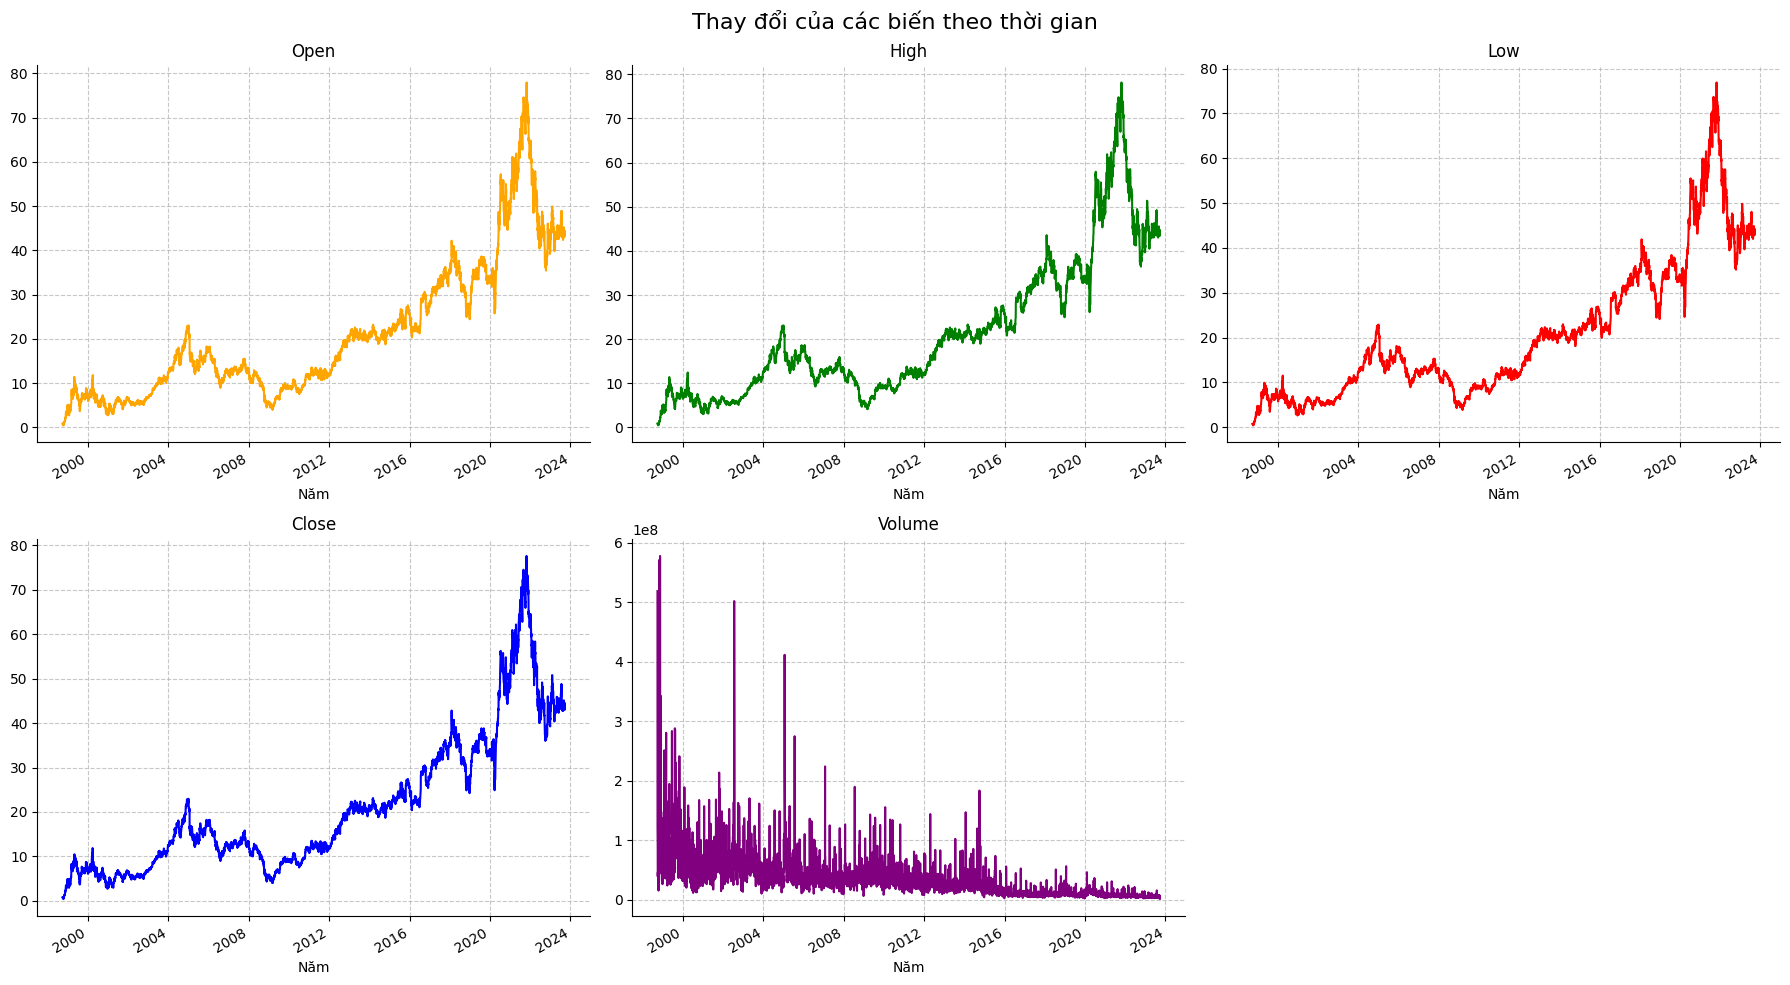

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Thay đổi của các biến theo thời gian', fontsize=16)

metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Volume', 'purple', 'Volume')
}

for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

* Tất cả các biểu đồ ngoại trừ "Volume" đều có một dạng tương tự và đó là bởi vì sau giá mở cửa, thị trường chứng khoán thường có một biến động nhỏ lên xuống khiến cho các biểu đồ giá này tuân theo cùng một mô hình nhưng đối với cột "Volume" thì đây là một quá trình khá ngẫu nhiên đối với lượng giao dịch trong một ngày nhất định.

## Box plot

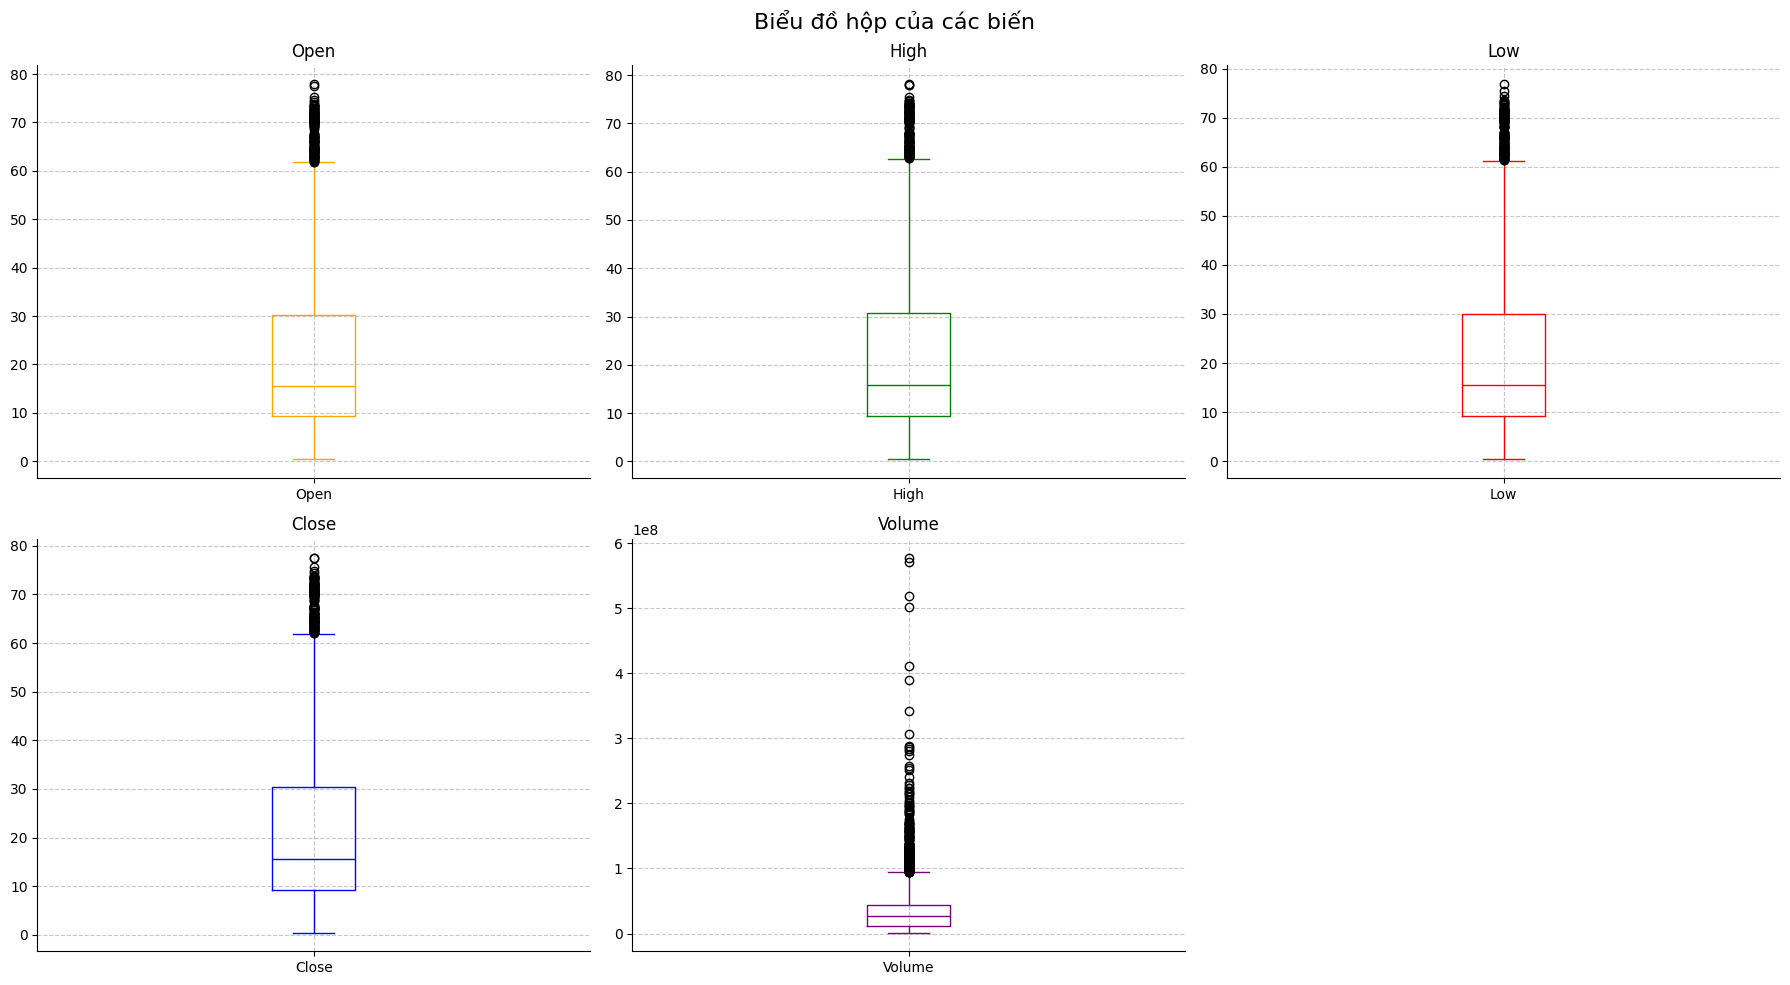

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Biểu đồ hộp của các biến', fontsize=16)

metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Volume', 'purple', 'Volume')
}

for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot.box(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

* Đối với các biến về giá, có thể nhận thấy rằng nhìn chung chúng được phân bổ tốt nhưng biến "Volume" chứa một số giá trị ngoại lệ. Điều này được giải thích bởi thực tế là khi cổ phiếu giao dịch bắt đầu tăng thì giá trị giá giảm xuống, giải thích cho sự sụt giảm đột ngột về giá và "Volume" đạt đỉnh.

## Tỷ lệ tăng trưởng

* Tỷ lệ tăng trưởng là phần trăm thay đổi của một giá trị trong một khoảng thời gian cụ thể. Công thức tính là:
$
\text{Growth Rate} = \frac{\text{New Value} - \text{Old Value}}{\text{Old Value}} \times 100\%
$

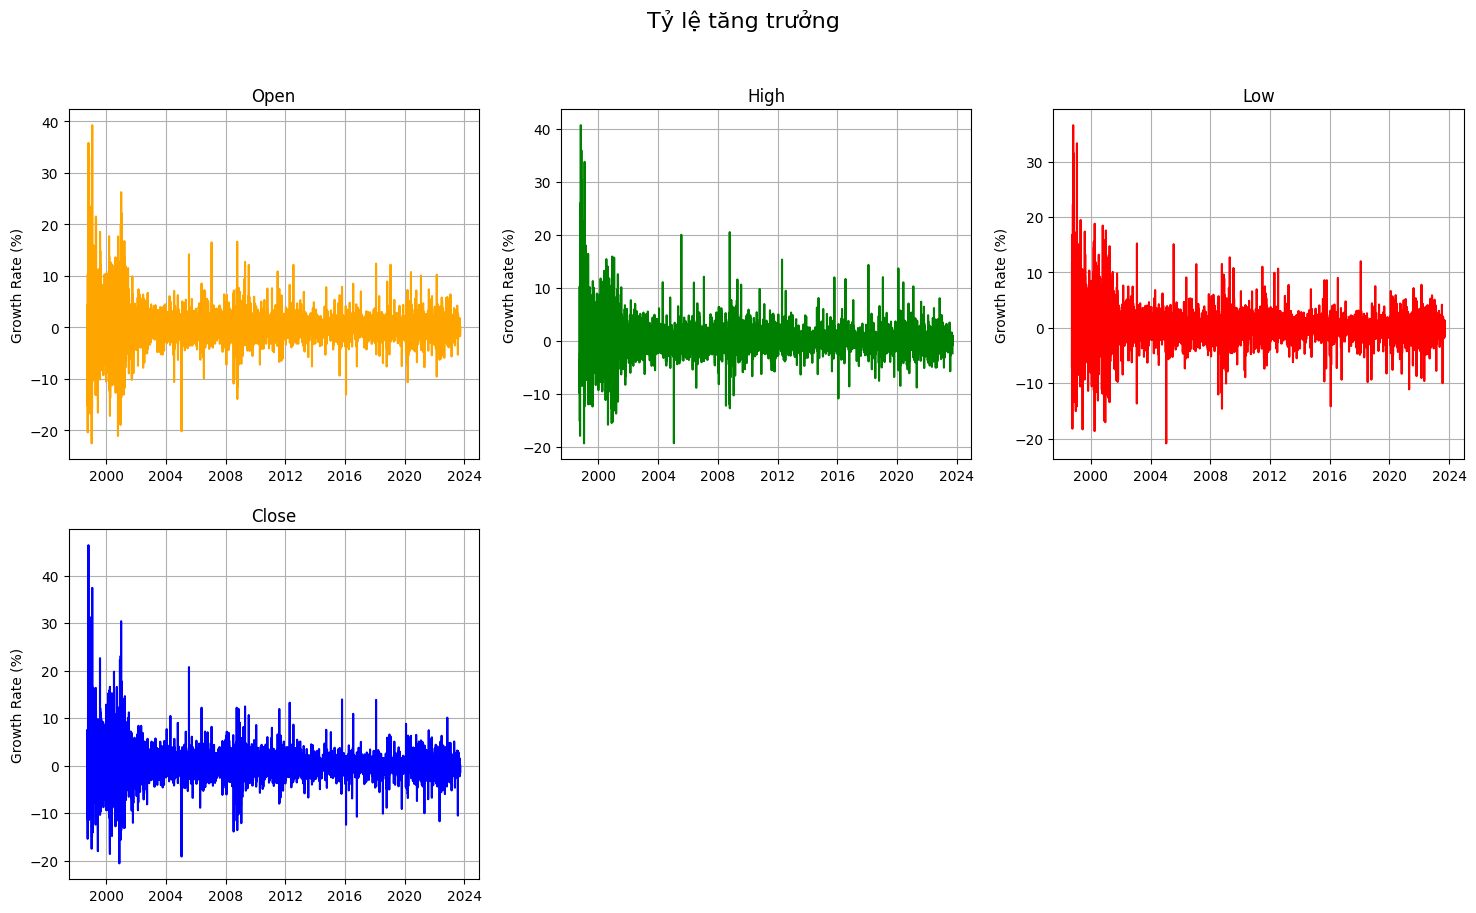

In [12]:
plt.figure(figsize=(18,10))
plt.suptitle("Tỷ lệ tăng trưởng", fontsize=16)
i=1
colors = ['orange', 'green', 'red', 'blue', 'brown', 'purple']
for x, color in zip(df.columns[:-1], colors):
    plt.subplot(2,3,i)
    df['Growth Rate'] = (df[x] - df[x].shift(1)) / df[x].shift(1) * 100
    plt.plot(df.index, df['Growth Rate'], linestyle='-', color=color)
    plt.xlabel(None)
    plt.ylabel('Growth Rate (%)')
    plt.title(f'{x}')
    plt.grid(True)
    i+=1
plt.show()

* Ở các biến giá thì tỷ lệ tăng trưởng biến động khá cao ở khoảng độ giữa năm 2020 và 2021, đỉnh điểm của dịch Covid-19

## Ma trận tương quan

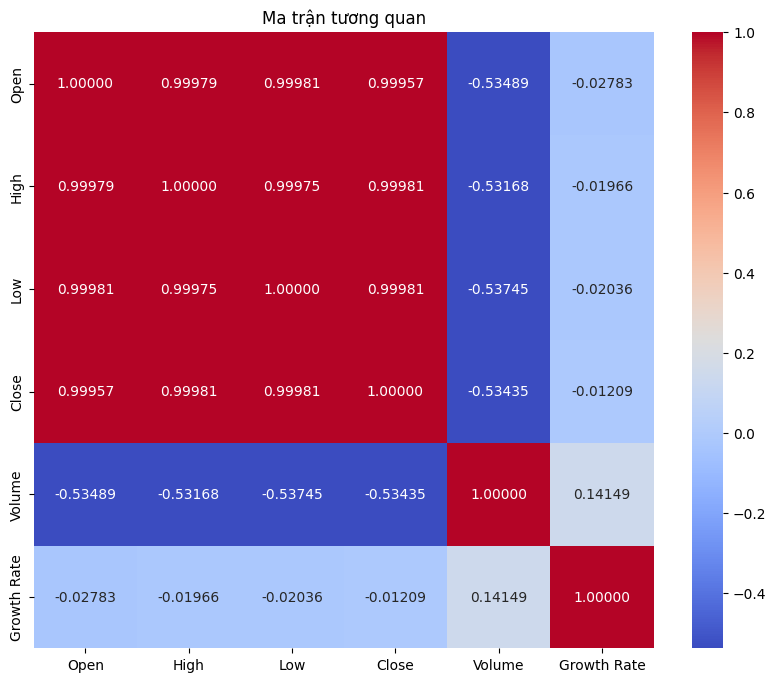

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".5f")
plt.title('Ma trận tương quan')
plt.show()

* Ma trận này thể hiện mối liên hệ rất tuyến tính mạnh giữa các giá trị về giá (High, Low, Open, Close, Adj Close).
* "Volume" có mối tương quan âm với các biến giá, nghĩa là khi "Volume" tăng, các giá trị về giá có xu hướng giảm nhẹ, nhưng mối quan hệ này không quá mạnh.

# Chuẩn bị dữ liệu

In [14]:
closing_price = df[['Close']]

window_size = 15 #14 input values and 15th value is the target

In [15]:
from src.split_data import split_data
#Preparing inputs
scaler,X_train, y_train, X_test, y_test = split_data(closing_price, window_size)

In [16]:
#Converting data to tensors for the model
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_rnn = y_train_lstm = y_train_gru = y_train_ann =torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = y_test_lstm = y_test_gru = y_test_ann = torch.from_numpy(y_test).type(torch.Tensor)

# Chạy mô hình RNN

In [17]:
from src.rnn import RNN

In [18]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
rnn_model = RNN(num_input, num_hidden, num_layer, num_output)

In [19]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.01
rnn_criterion = nn.MSELoss(reduction = 'mean')
rnn_updater = torch.optim.Adam(rnn_model.parameters(), lr = lr)

In [20]:
#Training RNN model
train_hist_rnn = np.zeros(num_epochs)
val_hist_rnn = np.zeros(num_epochs)
for epoch in range(num_epochs):
    y_train_pred_rnn = rnn_model(X_train)
    loss = rnn_criterion(y_train_pred_rnn, y_train_rnn)
    train_hist_rnn[epoch] = loss.item()
    with torch.no_grad():
        y_val_pred_rnn = rnn_model(X_test)
        val_loss = rnn_criterion(y_val_pred_rnn, y_test_rnn)
        val_hist_rnn[epoch] = val_loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    rnn_updater.zero_grad()
    loss.backward()
    rnn_updater.step()

Epoch  0 MSE:  0.4029700756072998
Epoch  5 MSE:  0.18184944987297058
Epoch  10 MSE:  0.1257871389389038
Epoch  15 MSE:  0.09758365899324417
Epoch  20 MSE:  0.060398343950510025
Epoch  25 MSE:  0.041536130011081696
Epoch  30 MSE:  0.021046433597803116
Epoch  35 MSE:  0.015165233984589577
Epoch  40 MSE:  0.012005110271275043
Epoch  45 MSE:  0.012713943608105183
Epoch  50 MSE:  0.011036613024771214
Epoch  55 MSE:  0.008957471698522568
Epoch  60 MSE:  0.0077101243659853935
Epoch  65 MSE:  0.006938480772078037
Epoch  70 MSE:  0.006480630952864885
Epoch  75 MSE:  0.005920250900089741
Epoch  80 MSE:  0.005336542148143053
Epoch  85 MSE:  0.004886873532086611
Epoch  90 MSE:  0.004528348334133625
Epoch  95 MSE:  0.004201957955956459


Text(0, 0.5, 'Loss')

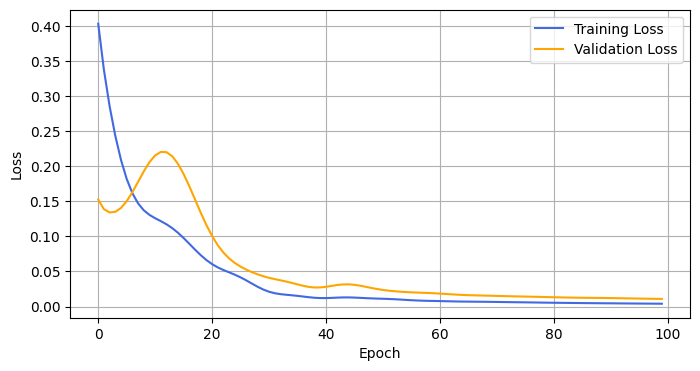

In [21]:
#Training loss for RNN model
rcParams['figure.figsize'] = 8,4
sns.lineplot(data = train_hist_rnn, color = 'royalblue', label = 'Training Loss')
sns.lineplot(data = val_hist_rnn, color = 'orange', label = 'Validation Loss')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title("RNN model loss")

# ANN

In [22]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
#Model specifics
num_input, num_hidden, num_output = 14, 4, 1
ann_model = ANN(num_input, num_hidden, num_output)

#Loss and optimiser functions
num_epochs, lr = 100, 0.01
ann_criterion = nn.MSELoss(reduction = 'mean')
ann_updater = torch.optim.Adam(ann_model.parameters(), lr = lr)

#Training ANN model
train_hist_ann = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred_ann = ann_model(X_train)

    loss = ann_criterion(y_train_pred_ann, y_train_ann)
    train_hist_ann[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    ann_updater.zero_grad()
    loss.backward()
    ann_updater.step()

Epoch  0 MSE:  0.19747288525104523
Epoch  5 MSE:  0.15700265765190125
Epoch  10 MSE:  0.13384407758712769
Epoch  15 MSE:  0.11311713606119156
Epoch  20 MSE:  0.09492967277765274
Epoch  25 MSE:  0.06574954092502594
Epoch  30 MSE:  0.02836785838007927
Epoch  35 MSE:  0.007307848893105984
Epoch  40 MSE:  0.009445881471037865
Epoch  45 MSE:  0.008919524028897285
Epoch  50 MSE:  0.0038303083274513483
Epoch  55 MSE:  0.0025969401467591524
Epoch  60 MSE:  0.002940906910225749
Epoch  65 MSE:  0.0025478678289800882
Epoch  70 MSE:  0.001898060436360538
Epoch  75 MSE:  0.0017137139802798629
Epoch  80 MSE:  0.0017355189193040133
Epoch  85 MSE:  0.0016222853446379304
Epoch  90 MSE:  0.001506214146502316
Epoch  95 MSE:  0.0014680137392133474


In [23]:
#ANN model performance on testing data
ann_model.eval()
y_test_pred_ann = ann_model(X_test)

ann_train_pred = scaler.inverse_transform(y_train_pred_ann.detach().numpy())
ann_train_orig = scaler.inverse_transform(y_train_ann.detach().numpy())
ann_test_pred = scaler.inverse_transform(y_test_pred_ann.detach().numpy())
ann_test_orig = scaler.inverse_transform(y_test_ann.detach().numpy())

In [24]:
from src.calculate_metrics import calculate_metrics
train_ann_rmse, train_ann_mse, train_ann_mae, train_ann_mape, train_ann_r2 = calculate_metrics(ann_train_orig[:, 0], ann_train_pred[:, 0])
test_ann_rmse, test_ann_mse, test_ann_mae, test_ann_mape, test_ann_r2 = calculate_metrics(ann_test_orig[:, 0], ann_test_pred[:, 0])

print('Train:')
print(f'RMSE: {train_ann_rmse:.4f}')
print(f'MSE: {train_ann_mse:.4f}')
print(f'MAE: {train_ann_mae:.4f}')
print(f'MAPE: {train_ann_mape:.4f}')
print(f'R2: {train_ann_r2:.4f}')

print('\nTest:')
print(f'RMSE: {test_ann_rmse:.4f}')
print(f'MSE: {test_ann_mse:.4f}')
print(f'MAE: {test_ann_mae:.4f}')
print(f'MAPE: {test_ann_mape:.4f}')
print(f'R2: {test_ann_r2:.4f}')

Train:
RMSE: 0.2162
MSE: 0.0467
MAE: 0.1592
MAPE: 0.0438
R2: 0.9912

Test:
RMSE: 0.6182
MSE: 0.3822
MAE: 0.4599
MAPE: 0.0829
R2: 0.9062


# Chạy mô hình LSTM

In [25]:
from src.lstm import LSTM

In [26]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
lstm_model = LSTM(num_input, num_hidden, num_layer, num_output)

In [27]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.01
lstm_criterion = nn.MSELoss(reduction = 'mean')
lstm_updater = torch.optim.Adam(lstm_model.parameters(), lr = lr)

In [28]:
#Training LSTM model
train_hist_lstm = np.zeros(num_epochs)
val_hist_lstm = np.zeros(num_epochs)
for epoch in range(num_epochs):
    y_train_pred_lstm = lstm_model(X_train)
    loss = lstm_criterion(y_train_pred_lstm, y_train_lstm)
    train_hist_lstm[epoch] = loss.item()
    with torch.no_grad():
        y_val_pred_lstm = lstm_model(X_test)
        val_loss = lstm_criterion(y_val_pred_lstm, y_test_lstm)
        val_hist_lstm[epoch] = val_loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    lstm_updater.zero_grad()
    loss.backward()
    lstm_updater.step()

Epoch  0 MSE:  0.353167325258255
Epoch  5 MSE:  0.2226106971502304
Epoch  10 MSE:  0.13450850546360016
Epoch  15 MSE:  0.10175107419490814
Epoch  20 MSE:  0.0961376279592514
Epoch  25 MSE:  0.06749061495065689
Epoch  30 MSE:  0.04952368140220642
Epoch  35 MSE:  0.031952280551195145
Epoch  40 MSE:  0.0191225316375494
Epoch  45 MSE:  0.018087295815348625
Epoch  50 MSE:  0.017973607406020164
Epoch  55 MSE:  0.013978887349367142
Epoch  60 MSE:  0.011265709064900875
Epoch  65 MSE:  0.009855573996901512
Epoch  70 MSE:  0.008513493463397026
Epoch  75 MSE:  0.006927885580807924
Epoch  80 MSE:  0.005583855789154768
Epoch  85 MSE:  0.004605676978826523
Epoch  90 MSE:  0.003722433466464281
Epoch  95 MSE:  0.0029727108776569366


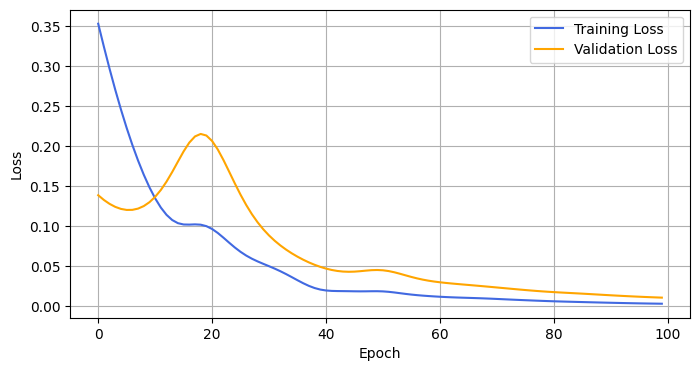

In [29]:
#Training loss for LSTM model
rcParams['figure.figsize'] = 8,4
sns.lineplot(data = train_hist_lstm, color = 'royalblue', label='Training Loss')
sns.lineplot(data = val_hist_lstm, color = 'orange', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
# plt.title("LSTM training loss")
plt.legend() # Show the legend
plt.show()

In [30]:
from src.gru import GRU
gru_model = GRU(num_input, num_hidden, num_layer, num_output)

In [31]:
num_epochs, lr = 100, 0.01
gru_criterion = nn.MSELoss(reduction = 'mean')
gru_updater = torch.optim.Adam(gru_model.parameters(), lr = lr)

In [32]:
#Training GRU model
train_hist_gru = np.zeros(num_epochs)
val_hist_gru = np.zeros(num_epochs)
for epoch in range(num_epochs):
    y_train_pred_gru = gru_model(X_train)
    loss = gru_criterion(y_train_pred_gru, y_train_gru)
    train_hist_gru[epoch] = loss.item()
    with torch.no_grad():
        y_val_pred_gru = gru_model(X_test)
        val_loss = gru_criterion(y_val_pred_gru, y_test_gru)
        val_hist_gru[epoch] = val_loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    gru_updater.zero_grad()
    loss.backward()
    gru_updater.step()

Epoch  0 MSE:  0.8354967832565308
Epoch  5 MSE:  0.45528972148895264
Epoch  10 MSE:  0.21622703969478607
Epoch  15 MSE:  0.13470607995986938
Epoch  20 MSE:  0.13488200306892395
Epoch  25 MSE:  0.11620654910802841
Epoch  30 MSE:  0.07843820005655289
Epoch  35 MSE:  0.055222850292921066
Epoch  40 MSE:  0.04281356558203697
Epoch  45 MSE:  0.025307057425379753
Epoch  50 MSE:  0.011579092592000961
Epoch  55 MSE:  0.007488396018743515
Epoch  60 MSE:  0.005998122971504927
Epoch  65 MSE:  0.006745803635567427
Epoch  70 MSE:  0.006095207761973143
Epoch  75 MSE:  0.00481522548943758
Epoch  80 MSE:  0.004166045226156712
Epoch  85 MSE:  0.0038093184120953083
Epoch  90 MSE:  0.0036960942670702934
Epoch  95 MSE:  0.0034548707772046328


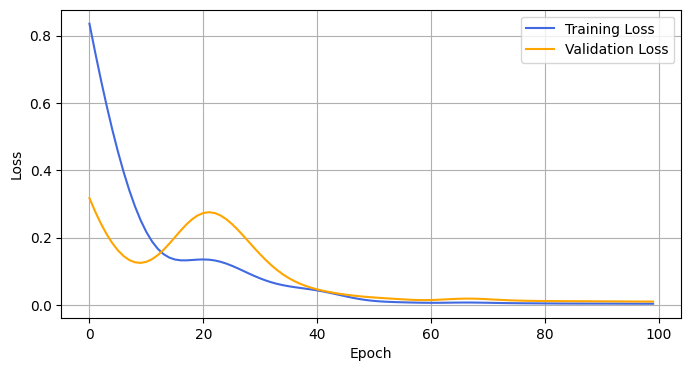

In [33]:
#Training loss for GRU model
rcParams['figure.figsize'] = 8,4
sns.lineplot(data = train_hist_gru, color = 'royalblue', label = 'Training Loss')
sns.lineplot(data = val_hist_gru, color = 'orange', label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
# plt.title("GRU model loss")

# Test hiệu năng

## RNN

In [34]:
#RNN model performance on testing data
rnn_model.eval()
y_test_pred_rnn = rnn_model(X_test)

In [35]:
#Converting the data back to its original form
rnn_train_pred = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
rnn_train_orig = scaler.inverse_transform(y_train_rnn.detach().numpy())
rnn_test_pred = scaler.inverse_transform(y_test_pred_rnn.detach().numpy())
rnn_test_orig = scaler.inverse_transform(y_test_rnn.detach().numpy())

In [36]:
from src.calculate_metrics import calculate_metrics
train_rnn_rmse, train_rnn_mse, train_rnn_mae, train_rnn_mape, train_rnn_r2 = calculate_metrics(rnn_train_orig[:, 0], rnn_train_pred[:, 0])

# Calculate metrics for testing data
test_rnn_rmse, test_rnn_mse, test_rnn_mae, test_rnn_mape, test_rnn_r2 = calculate_metrics(rnn_test_orig[:, 0], rnn_test_pred[:, 0])

# Print the metrics
print('Train:')
print(f'RMSE: {train_rnn_rmse:.4f}')
print(f'MSE: {train_rnn_mse:.4f}')
print(f'MAE: {train_rnn_mae:.4f}')
print(f'MAPE: {train_rnn_mape:.4f}')
print(f'R2: {train_rnn_r2:.4f}')

print('\nTest:')
print(f'RMSE: {test_rnn_rmse:.4f}')
print(f'MSE: {test_rnn_mse:.4f}')
print(f'MAE: {test_rnn_mae:.4f}')
print(f'MAPE: {test_rnn_mape:.4f}')
print(f'R2: {test_rnn_r2:.4f}')

Train:
RMSE: 0.3585
MSE: 0.1285
MAE: 0.2768
MAPE: 0.0828
R2: 0.9758

Test:
RMSE: 0.5900
MSE: 0.3481
MAE: 0.4434
MAPE: 0.0779
R2: 0.9146


In [37]:
#Preparing predictions for the plot comparisons for RNN model
rnn_train_data = np.append(rnn_train_orig, rnn_train_pred, axis = 1)
rnn_test_data = np.append(rnn_test_orig, rnn_test_pred, axis = 1)

rnn_train_plot = pd.DataFrame(rnn_train_data)
rnn_train_plot.columns = ['Actual', 'Predicted']
rnn_test_plot = pd.DataFrame(rnn_test_data)
rnn_test_plot.columns = ['Actual', ' Predicted']

Text(0, 0.5, 'Closing')

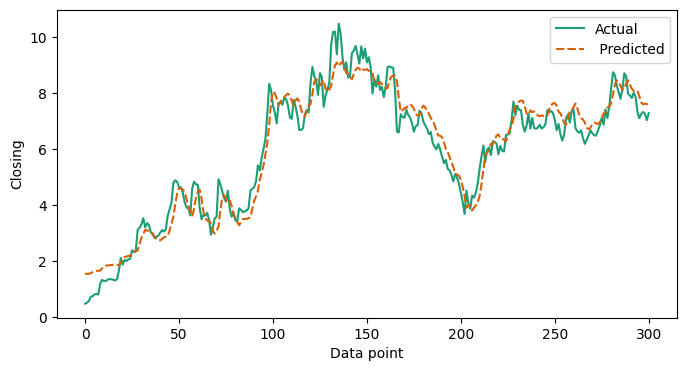

In [54]:
#Predictions vs actual price for the RNN model
sns.set_palette('Dark2')

# fig, axes = plt.subplots(1, 1, sharex = False, figsize = (13,6))
# fig.suptitle('Actual vs predicted prices for all models')

# rnn_training_plot = sns.lineplot(ax = axes[0], data = rnn_train_plot)
# rnn_training_plot.set_title('RNN (training)')
# rnn_training_plot.set_xlabel('Data point')
# rnn_training_plot.set_ylabel('Closing')

rnn_testing_plot = sns.lineplot(data = rnn_test_plot[0:301])
# rnn_testing_plot.set_title('RNN (testing)')
rnn_testing_plot.set_xlabel('Data point')
rnn_testing_plot.set_ylabel('Closing')

## GRU

In [39]:
gru_model.eval()
y_test_pred_gru = gru_model(X_test)

In [40]:
#Converting the data back to its original form
gru_train_pred = scaler.inverse_transform(y_train_pred_gru.detach().numpy())
gru_train_orig = scaler.inverse_transform(y_train_gru.detach().numpy())
gru_test_pred = scaler.inverse_transform(y_test_pred_gru.detach().numpy())
gru_test_orig = scaler.inverse_transform(y_test_gru.detach().numpy())

In [41]:
from src.calculate_metrics import calculate_metrics
train_gru_rmse, train_gru_mse, train_gru_mae, train_gru_mape, train_gru_r2 = calculate_metrics(gru_train_orig[:, 0], gru_train_pred[:, 0])
test_gru_rmse, test_gru_mse, test_gru_mae, test_gru_mape, test_gru_r2 = calculate_metrics(gru_test_orig[:, 0], gru_test_pred[:, 0])

print('Train:')
print(f'RMSE: {train_gru_rmse:.4f}')
print(f'MSE: {train_gru_mse:.4f}')
print(f'MAE: {train_gru_mae:.4f}')
print(f'MAPE: {train_gru_mape:.4f}')
print(f'R2: {train_gru_r2:.4f}')

print('\nTest:')
print(f'RMSE: {test_gru_rmse:.4f}')
print(f'MSE: {test_gru_mse:.4f}')
print(f'MAE: {test_gru_mae:.4f}')
print(f'MAPE: {test_gru_mape:.4f}')
print(f'R2: {test_gru_r2:.4f}')

Train:
RMSE: 0.3262
MSE: 0.1064
MAE: 0.2411
MAPE: 0.0779
R2: 0.9800

Test:
RMSE: 0.5569
MSE: 0.3102
MAE: 0.4035
MAPE: 0.0720
R2: 0.9239


In [42]:
gru_train_data = np.append(gru_train_orig, gru_train_pred, axis = 1)
gru_test_data = np.append(gru_test_orig, gru_test_pred, axis = 1)

gru_train_plot = pd.DataFrame(gru_train_data)
gru_train_plot.columns = ['Actual', 'Predicted']
gru_test_plot = pd.DataFrame(gru_test_data)
gru_test_plot.columns = ['Actual', ' Predicted']

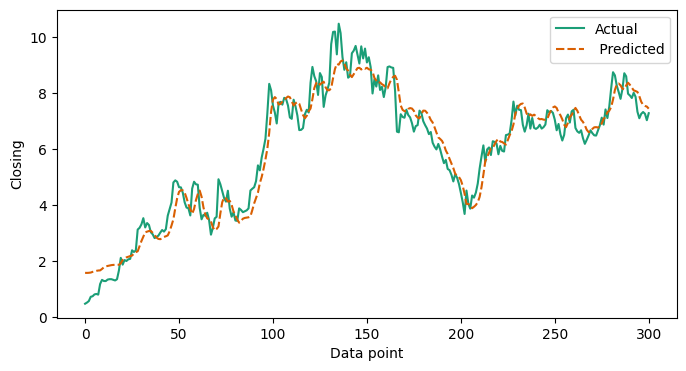

In [53]:
# fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
# fig.suptitle('Actual vs predicted prices for all models')

# gru_training_plot = sns.lineplot(ax = axes[0], data = gru_train_plot)
# gru_training_plot.set_title('GRU (training)')
# gru_training_plot.set_xlabel('Data point')
# gru_training_plot.set_ylabel('Closing')

gru_testing_plot = sns.lineplot(data = gru_test_plot[0:301])
# gru_testing_plot.set_title('GRU (testing)')
gru_testing_plot.set_xlabel('Data point')
gru_testing_plot.set_ylabel('Closing');


## LSTM

In [44]:
#LSTM model performance on testing data
lstm_model.eval()
y_test_pred_lstm = lstm_model(X_test)

In [45]:
#Converting the data back to its original form
lstm_train_pred = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
lstm_train_orig = scaler.inverse_transform(y_train_lstm.detach().numpy())
lstm_test_pred = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
lstm_test_orig = scaler.inverse_transform(y_test_lstm.detach().numpy())

In [46]:
from src.calculate_metrics import calculate_metrics
train_lstm_rmse, train_lstm_mse, train_lstm_mae, train_lstm_mape, train_lstm_r2 = calculate_metrics(lstm_train_orig[:, 0], lstm_train_pred[:, 0])

# Calculate metrics for testing data
test_lstm_rmse, test_lstm_mse, test_lstm_mae, test_lstm_mape, test_lstm_r2 = calculate_metrics(lstm_test_orig[:, 0], lstm_test_pred[:, 0])

# Print the metrics
print('Train:')
print(f'RMSE: {train_lstm_rmse:.4f}')
print(f'MSE: {train_lstm_mse:.4f}')
print(f'MAE: {train_lstm_mae:.4f}')
print(f'MAPE: {train_lstm_mape:.4f}')
print(f'R2: {train_lstm_r2:.4f}')

print('\nTest:')
print(f'RMSE: {test_lstm_rmse:.4f}')
print(f'MSE: {test_lstm_mse:.4f}')
print(f'MAE: {test_lstm_mae:.4f}')
print(f'MAPE: {test_lstm_mape:.4f}')
print(f'R2: {test_lstm_r2:.4f}')

Train:
RMSE: 0.2863
MSE: 0.0820
MAE: 0.1828
MAPE: 0.0535
R2: 0.9846

Test:
RMSE: 0.5670
MSE: 0.3215
MAE: 0.3991
MAPE: 0.0671
R2: 0.9211


In [47]:
#Preparing predictions for the plot comparisons
lstm_train_data = np.append(lstm_train_orig, lstm_train_pred, axis = 1)
lstm_test_data = np.append(lstm_test_orig, lstm_test_pred, axis = 1)

lstm_train_plot = pd.DataFrame(lstm_train_data)
lstm_train_plot.columns = ['Actual', 'Predicted']
lstm_test_plot = pd.DataFrame(lstm_test_data)
lstm_test_plot.columns = ['Actual', ' Predicted']

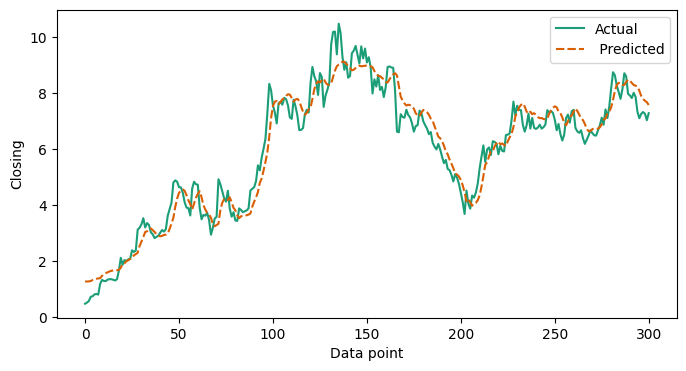

In [55]:
#Prediction vs actual price for LSTM model
sns.set_palette('Dark2')

# fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
# fig.suptitle('Actual vs predicted prices for all models')

# lstm_training_plot = sns.lineplot(ax = axes[0], data = lstm_train_plot)
# lstm_training_plot.set_title('LSTM (training)')
# lstm_training_plot.set_xlabel('Data point')
# lstm_training_plot.set_ylabel('Closing')

lstm_testing_plot = sns.lineplot(data = lstm_test_plot[0:301])
# lstm_testing_plot.set_title('LSTM (testing)')
lstm_testing_plot.set_xlabel('Data point')
lstm_testing_plot.set_ylabel('Closing');


## Tổng hợp

| **Model** | **Dataset** | **RMSE** | **MSE**     | **MAE** | **MAPE** | **R²** |
|-----------|-------------|----------|-------------|---------|----------|--------|
| **RNN**   | Train       | 0.36     | 0.13        | 0.28    | 0.0828   | 0.98   |
|           | Test        | 0.59     | 0.35        | 0.44    | 0.0779   | 0.91   |
| **GRU**   | Train       | 0.20     | 0.04        | 0.15    | 0.0452   | 0.99   |
|           | Test        | 0.41     | 0.17        | 0.32    | 0.0568   | 0.96   |
| **LSTM**  | Train       | 0.16     | 0.02        | 0.11    | 0.0312   | 1.00   |
|           | Test        | 0.42     | 0.18        | 0.30    | 0.0526   | 0.96   |


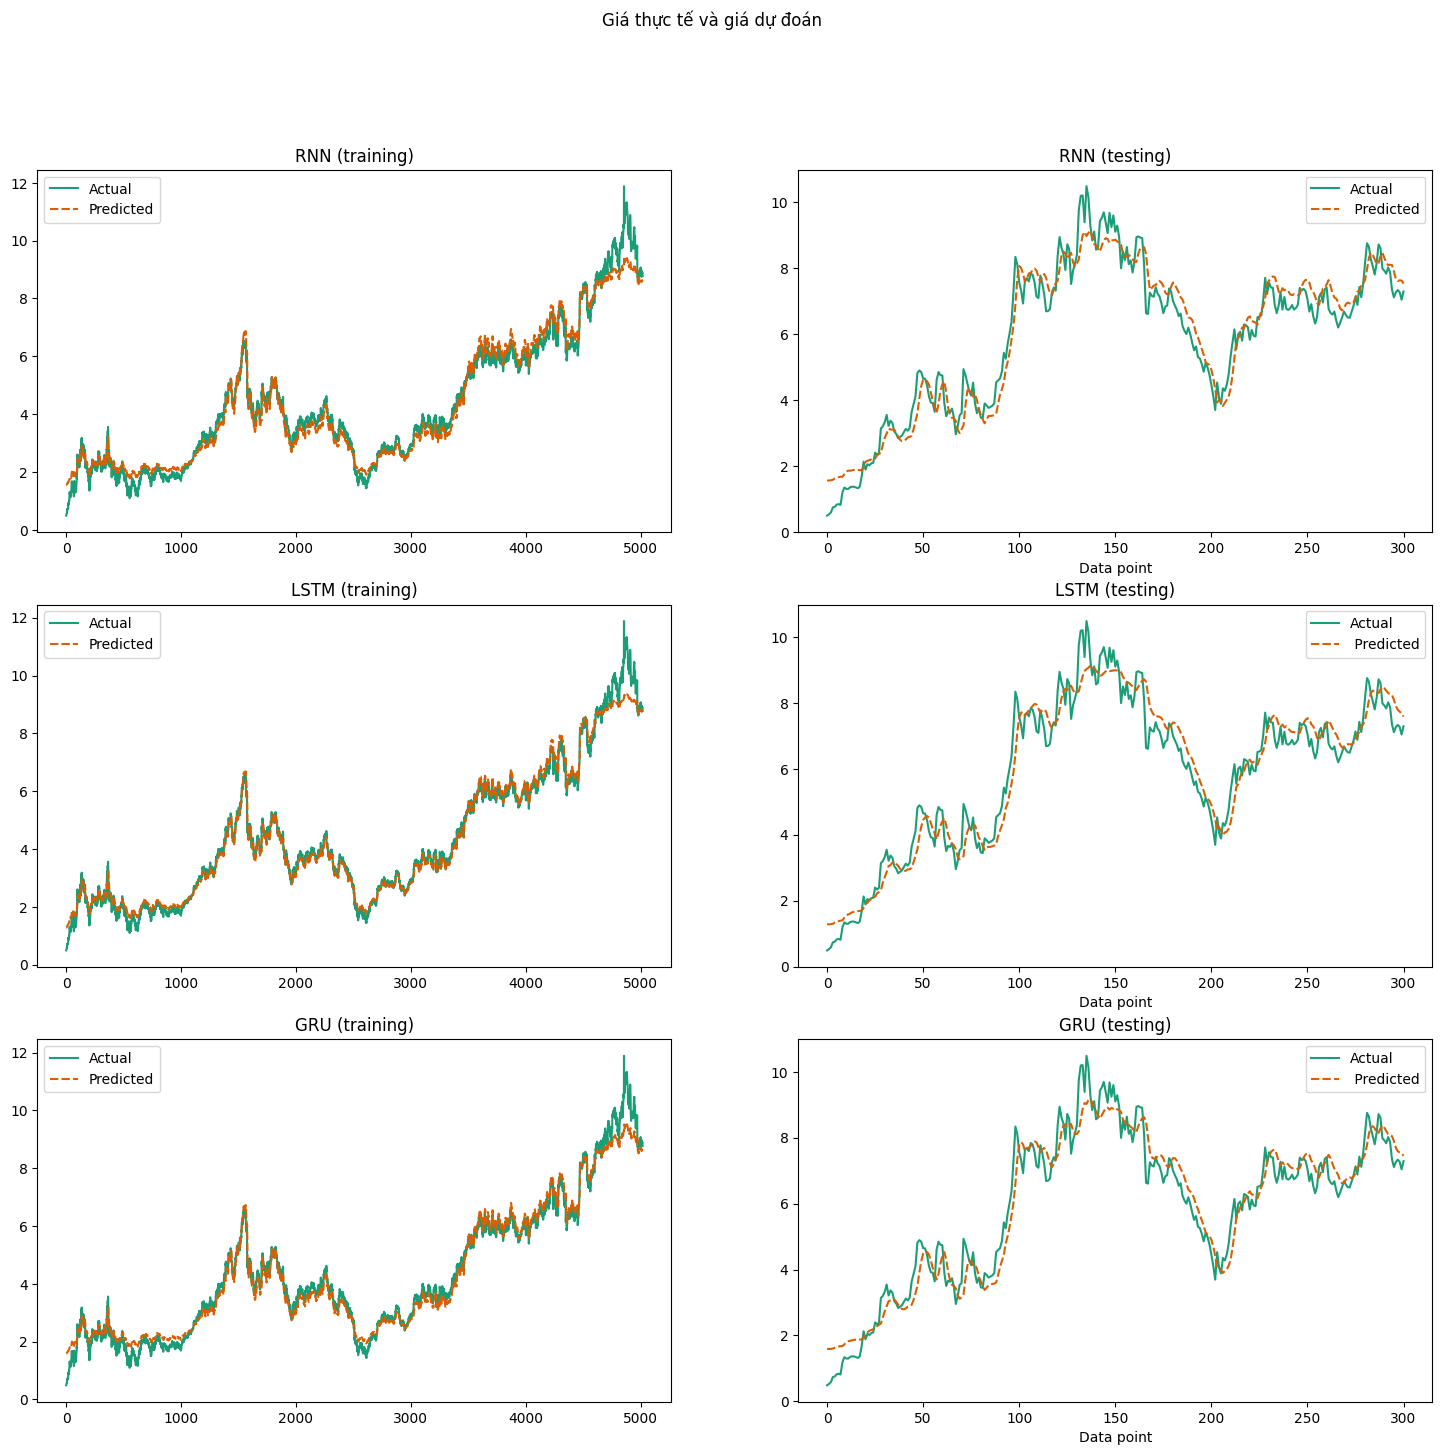

In [70]:
fig, axes = plt.subplots(3, 2, sharex = False, sharey =  False, figsize = (18,16))
fig.suptitle('Giá thực tế và giá dự đoán')

rnn_training_plot = sns.lineplot(ax = axes[0][0], data = rnn_train_plot)
rnn_training_plot.set_title('RNN (training)')

rnn_testing_plot = sns.lineplot(ax = axes[0][1], data = rnn_test_plot[0:301])
rnn_testing_plot.set_title('RNN (testing)')
rnn_testing_plot.set_xlabel('Data point')

lstm_training_plot = sns.lineplot(ax = axes[1][0], data = lstm_train_plot)
lstm_training_plot.set_title('LSTM (training)')

lstm_testing_plot = sns.lineplot(ax = axes[1][1], data = lstm_test_plot[0:301])
lstm_testing_plot.set_title('LSTM (testing)')
lstm_testing_plot.set_xlabel('Data point')

gru_training_plot = sns.lineplot(ax = axes[2][0], data = gru_train_plot)
gru_training_plot.set_title('GRU (training)')

gru_testing_plot = sns.lineplot(ax = axes[2][1], data = gru_test_plot[0:301])
gru_testing_plot.set_title('GRU (testing)')
gru_testing_plot.set_xlabel('Data point');

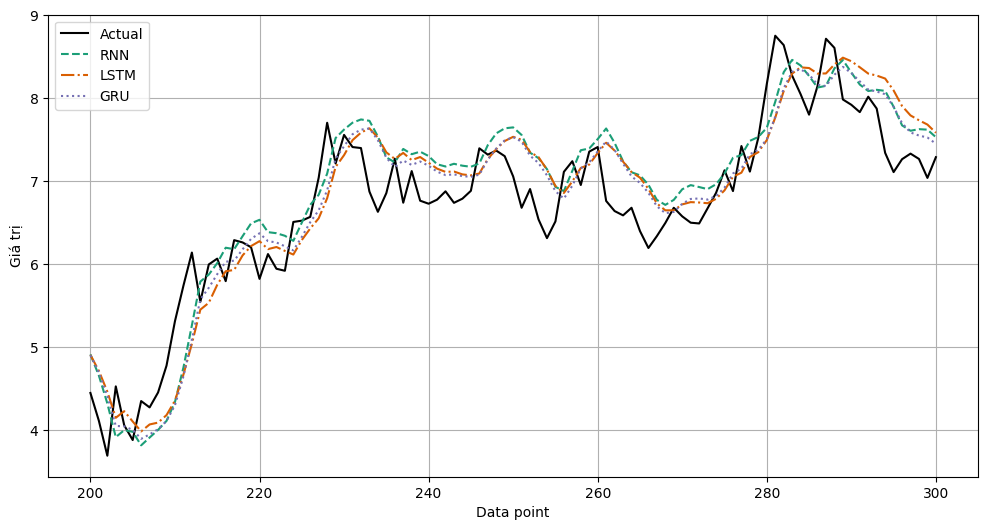

<Figure size 800x400 with 0 Axes>

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Lấy ra giá trị thực tế từ một trong các DataFrame (ví dụ: rnn_test_plot)
actual_values = rnn_test_plot[200:301]['Actual']

# Vẽ đường giá trị thực tế
plt.plot(actual_values.index, actual_values, label="Actual", color="black")

# Vẽ đường dự đoán của RNN
plt.plot(rnn_test_plot[200:301].index, rnn_test_plot[200:301][' Predicted'], label="RNN", linestyle="--")

# Vẽ đường dự đoán của LSTM
plt.plot(lstm_test_plot[200:301].index, lstm_test_plot[200:301][' Predicted'], label="LSTM", linestyle="-.")

# Vẽ đường dự đoán của GRU
plt.plot(gru_test_plot[200:301].index, gru_test_plot[200:301][' Predicted'], label="GRU", linestyle=":")

# Cấu hình biểu đồ
plt.xlabel('Data point')
plt.ylabel('Giá trị')
plt.legend()
plt.grid(True)  # Thêm lưới để dễ đọc hơn
plt.show()